# Merged model evaluation

In [1]:

import ProbabilisticParcellation.evaluate as ev
import ProbabilisticParcellation.util as ut
import ProbabilisticParcellation.functional_profiles as fp
import Functional_Fusion.dataset as ds
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
from scipy import stats
import glob
import numpy as np


In [24]:
# Import symmetric evaluation
Sym = pd.read_csv(
    f'{ut.model_dir}/Models/Evaluation/eval_dataset7_sym.tsv', sep='\t')
Sym['symmetry'] = 'Symmetric'

# Import asymmetric evaluation
Asym = pd.read_csv(
    f'{ut.model_dir}/Models/Evaluation/eval_dataset7_asym.tsv', sep='\t')
Asym['symmetry'] = 'Asymmetric'


In [25]:
Data = pd.concat([Sym, Asym], axis=0)

# Loop through rows and add indicator for those where train_data list is of length 6
Data['train_data'] = Data['train_data'].apply(lambda x: x.split("' '"))
Data['train_data_len'] = Data['train_data'].apply(lambda x: len(x))
# Make Training column 'Single' if train_data_len is 1, 'All' if train_data_len is 7 and 'Leave_one_out' if train_data_len is 6
Data['Training'] = Data['train_data_len'].apply(
    lambda x: 'Single' if x == 1 else 'Leave_one_out')
Data.loc[Data['train_data_len'] == 7, 'Training'] = 'All'



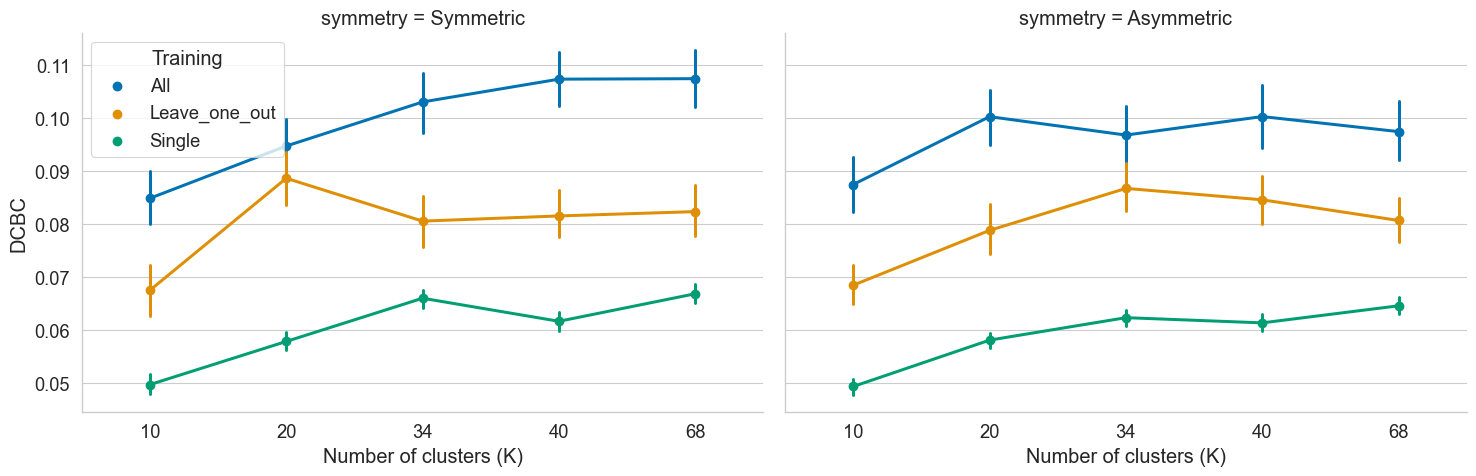

In [28]:
# Plot dcbc_group as a function of K with Hue = Training (# Plot only Ks where Symmetric and Asymmetric models have a value))
sb.set_style('whitegrid')
sb.set_context('paper', font_scale=1.5)
g = sb.catplot(x='K', y='dcbc_group', hue='Training', data=Data[Data['K'].isin([10, 20, 34, 40, 68, ])], kind='point', col='symmetry',
                palette='colorblind', height=5, aspect=1.5, legend_out=False)
g.set_axis_labels('Number of clusters (K)', 'DCBC')
g._legend.set_title('Training')
# plt.savefig(f'{ut.model_dir}/Figures/DCBC/DCBC_group.png', dpi=300)



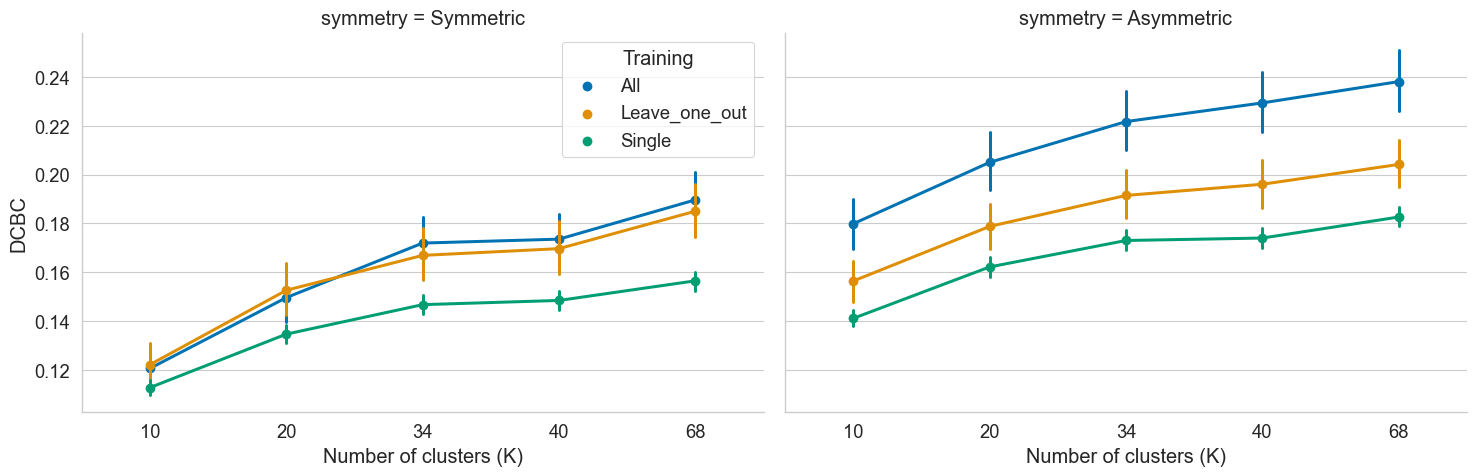

In [30]:
# Same plot for dcbc_individual
sb.set_style('whitegrid')
sb.set_context('paper', font_scale=1.5)
g = sb.catplot(x='K', y='dcbc_indiv', hue='Training', data=Data[Data['K'].isin([10, 20, 34, 40, 68, ])], kind='point', col='symmetry',
                palette='colorblind', height=5, aspect=1.5, legend_out=False)
g.set_axis_labels('Number of clusters (K)', 'DCBC')
g._legend.set_title('Training')
# plt.savefig(f'{ut.model_dir}/Figures/DCBC/DCBC_individual.png', dpi=300)